In [16]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import umap
from util import rebin, load_data

ImportError: cannot import name 'load_data' from 'util' (/home/dkuiper/Rep_Learn_FRB/util.py)

In [6]:
def plot_dynamic_spectra(dynamic_spectra, title="Dynamic Spectra"):
    """
    Plot a dynamic spectrum with horizontal time axis and reversed frequency axis.

    Parameters:
        dynamic_spectra (numpy.ndarray): The dynamic spectrum to plot.
        title (str): The title for the plot (default is "Dynamic Spectra").

    Returns:
        None
    """
    # Calculate the time step based on the number of time samples
    num_time_samples = dynamic_spectra.shape[0]
    time_step = 0.0000256  # Default time step in seconds

    # Calculate the extent based on the number of frequency channels
    extent = [0, num_time_samples * time_step * 1000, 1208, 1700]

    plt.figure(figsize=(10, 6))
    plt.imshow(dynamic_spectra.T, aspect="auto", cmap="viridis", extent=extent)
    plt.xlabel("Time (ms)", size=14)
    plt.ylabel("Frequency (MHz)", size=14)
    plt.colorbar()
    plt.title(title, size=16)
    plt.show()

In [7]:
# directories = [
#     "noiseless_1000_simple_narrow",
#     "noiseless_1000_simple_broad",
#     "noiseless_1000_simple_middle",
#     "noiseless_1000_simple_broad_narrow_time",
#     "noiseless_1000_scattered",
#     "noiseless_1000_complex",
#     "noiseless_1000_drifting",
# ]

# Define the directories containing the data for different classes
directories = [
    "1000_Constant_SNR_simple_narrow",
    "1000_Constant_SNR_simple_broad",
    "1000_Constant_SNR_simulated_scattered",
    "1000_Constant_SNR_complex",
    "1000_Constant_SNR_drifting",
]



## Standard Scale the data

In [8]:
# Create Standard Scaler
scaler = StandardScaler()
scaler.fit(data_train.reshape(-1, int(1024/4) * int(512/4)))

# Transform data
data_train_scaled = scaler.transform(data_train.reshape(-1, int(1024/4) * int(512/4)))
data_test_scaled = scaler.transform(data_test.reshape(-1, int(1024/4) * int(512/4)))

# Reshape the combined data for PCA
combined_data_2d_train = data_train_scaled
combined_data_2d_test = data_test_scaled


## In case we want Unscaled data

In [9]:
data_train_unscaled = data_train.reshape(-1, int(1024/4) * int(512/4))
data_test_unscaled = data_test.reshape(-1, int(1024/4) * int(512/4))

## What does the scaled burst look like?

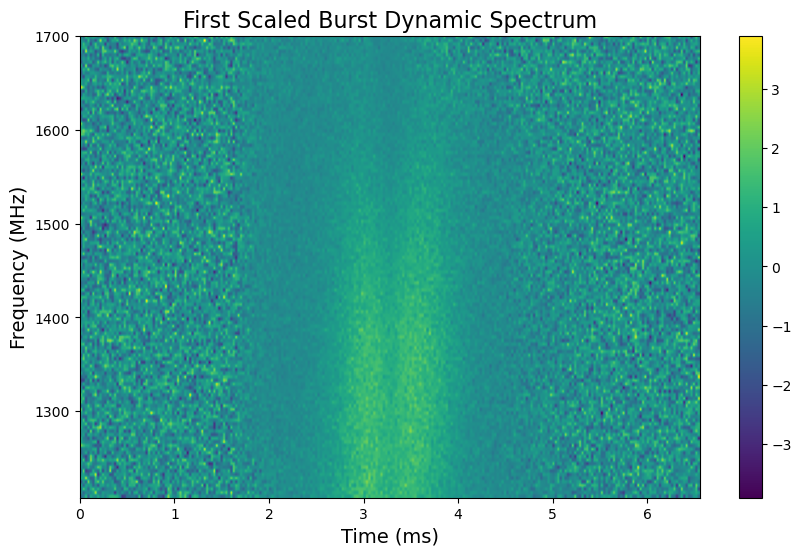

In [10]:
# Extract the first scaled burst
scaled_burst = data_train_scaled[200]

# Reshape the scaled burst to its original shape
scaled_burst_reshaped = scaled_burst.reshape(int(1024/4), int(512/4))

# Plot the dynamic spectrum of the first scaled burst
plot_dynamic_spectra(scaled_burst_reshaped, title="First Scaled Burst Dynamic Spectrum")

In [11]:
# Create a UMAP model
umap_model = umap.UMAP(n_components=8)

# Fit and transform the data
umap_result = umap_model.fit_transform(data_train_unscaled)

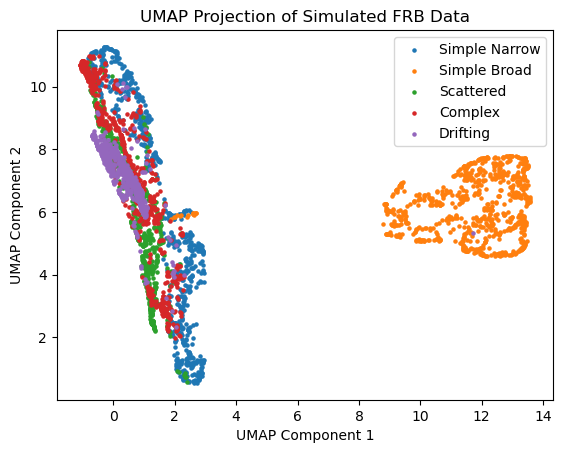

In [12]:
# Define labels for each directory
burst_labels = [
    "Simple Narrow",
    "Simple Broad",
    # "Simple Middle",
    # "Simple Broad Narrow Time",
    "Scattered",
    "Complex",
    "Drifting"
]

# Plot scatter plots for UMAP results, colored by burst directory
for i, label in enumerate(burst_labels):
    idx = labels_train == i
    plt.scatter(umap_result[idx, 0], umap_result[idx, 1], label=label, s=5)

plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.title('UMAP Projection of Simulated FRB Data')
plt.show()
    

In [13]:
from sklearn.neighbors import KDTree
import numpy as np

## Metric using K-NN and computing ratio of similar classes
def get_sim_class_umap(representations, labels, K=20):
    ## Return
    ##     - mean of the class-similarity ratio, 
    ##     - array of individual ratios (same number of examples as in representations)
    
    # Build a KDTree using the representations
    kdt = KDTree(representations, leaf_size=10, metric='euclidean')
    ratios = []
    
    ## For each example, get the K nearest neighbours in the representations set
    ## And compute the ratios of the neighbours that have the same labels (class) as the current point
    for i in range(len(representations)):
        ## We could find a smart way to weight by distance for a different type of metric, 
        ## e.g. computing vote and checking accuracy score
        distances, neighbors = kdt.query(representations[i].reshape(1,-1), k=K+1, return_distance=True)
        
        ## KDTree returns the indices of the K nearest neighbors but also include the current example if it's
        ## in the "training set"
        neighbors = neighbors[0][1:]
        ratio_ = np.sum(labels[neighbors]==labels[i])/K
        ratios.append(ratio_)
    return np.mean(np.array(ratios)), np.array(ratios)

# Compute
mean_ratio_umap, individual_ratios_umap = get_sim_class_umap(umap_result, labels_train)
print("Mean of the class-similarity ratio (UMAP):", mean_ratio_umap)
print("Array of individual ratios (UMAP):", individual_ratios_umap)

Mean of the class-similarity ratio (UMAP): 0.8170499999999999
Array of individual ratios (UMAP): [1.   0.8  0.85 ... 0.1  1.   1.  ]
